In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from matplotlib.image import imread
import os
import datetime
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.cm as cm
import keras
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import MaxPool2D,MaxPooling2D,Flatten,Dense,Conv2D,AveragePooling2D,Activation,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
classes = ['NORMAL', 'PNEUMONIA', 'COVID19']

class_dict={0:"NORMAL",
           1:"PNEUMONIA",
           2:"COVID19"}

change = {
'NORMAL' : '0',
'PNEUMONIA': '1',
'COVID19' : '2',
}

batch_size=32
epochs=150
image_w=224
image_h=224

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)


In [3]:
model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',padding = 'same',input_shape=(image_w,image_h,3),name='conv2d_0'))
model.add(MaxPool2D(2,name='pool_0'))

model.add(Conv2D(64,(3,3),activation='relu',padding = 'same',name='conv2d_1'))
model.add(MaxPool2D(2,name='pool_1'))

model.add(Conv2D(128,(3,3),activation='relu',padding = 'same',name='conv2d_2'))
model.add(MaxPool2D(2,name='pool_2'))

model.add(Conv2D(256,(3,3),activation='relu',padding = 'same',name='conv2d_3'))
model.add(MaxPool2D(2,name='pool_3'))

model.add(Conv2D(512,(3,3),activation='relu',padding = 'same',name='conv2d_4'))
model.add(MaxPool2D(2,name='pool_4'))

model.add(Flatten(name='flatten'))

model.add(Dense(512,activation='relu',name='Dense_0'))
model.add(Dropout(0.4,name="dropout_1"))

model.add(Dense(256,activation='relu',name='Dense_1'))
model.add(Dropout(0.2,name="dropout_2"))

model.add(Dense(3,activation='softmax',name='output'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
model.load_weights('CNN2.h5')

In [7]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()



# https://keras.io/examples/vision/grad_cam/
def superimposed_img(img, heatmap,pred_class,pred_prob_final):

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM

    plt.matshow(superimposed_img)

    plt.xticks([])
    plt.yticks([])

    plt.title('Predict: '+str(pred_class)+'\n Confidence: '+str(pred_prob_final)+"%",fontsize=25, weight='bold');

    plt.show()


In [8]:
last_conv_layer_name = "conv2d_4"
classifier_layer_names = [
    'pool_4',
    "flatten",
    "Dense_0",
    "dropout_1",
    "Dense_1",
    "dropout_2",
]

In [9]:
def img_rgb(img_test_path):

    test_image=cv2.imread(img_test_path,cv2.IMREAD_COLOR)
    test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    test_image=cv2.resize(test_image,(224,224))
    
    return test_image 


def imshow(img_test_path):
    
    img_test_list=list(img_test_path.split('/'))
    test_image=img_rgb(img_test_path)
    plt.xticks([])
    plt.yticks([])
    plt.title('the Actual Class: :{}'.format(img_test_list[-2]),fontsize=25)
    plt.imshow(test_image)
    plt.show()
    

    
def show_visual_img(img_test_path):
    
    test_image=img_rgb(img_test_path)
    
    test_image=np.expand_dims(test_image,axis=0)
    
    img=img_rgb(img_test_path)
    
    img=np.expand_dims(img,axis=0)

    img=img/255.0
    
    score = model.predict(img)


    pred_class_num=np.argmax(score)
#     print(pred_class_num)
    pred_class=class_dict[pred_class_num]
#     print(pred_class)

    pred_prob=np.max(score) * 100
#     print(pred_prob)
    pred_prob_final=round(pred_prob,2)

    heatmap, top_index = make_gradcam_heatmap(test_image, 
                                              model, 
                                              last_conv_layer_name, 
                                              classifier_layer_names)

    superimposed_img(test_image[0], heatmap,pred_class,pred_prob_final)

1/1 [==============================] - 0s 46ms/step


C:\Users\sherif\AppData\Local\Temp\ipykernel_11520\1178612608.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


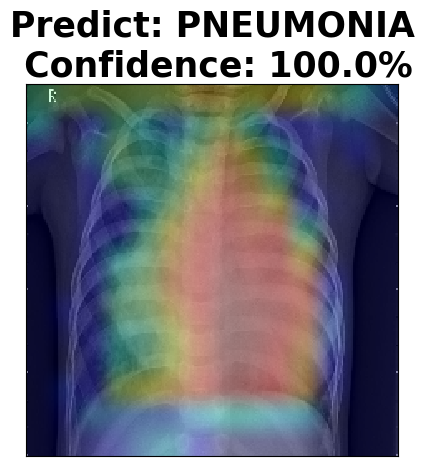

In [18]:
img_test_path='PNEUMONIA(3420).jpg'
show_visual_img(img_test_path)

1/1 [==============================] - 0s 46ms/step


C:\Users\sherif\AppData\Local\Temp\ipykernel_11520\1178612608.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


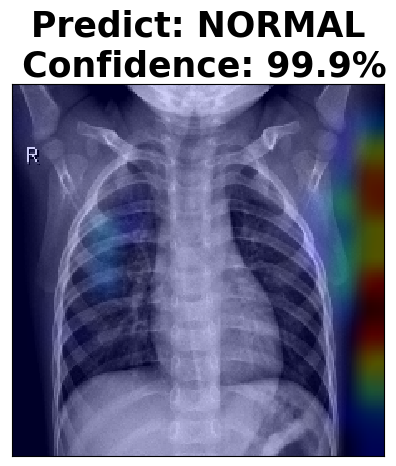

In [17]:
img_test_path='NORMAL(1272).jpg'
show_visual_img(img_test_path)